### Loading previous model

In [1]:
from keras.models import load_model
model = load_model('Rishabh_model_1.h5')
model.summary()

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
__________

### Preprocessing a single image

In [2]:
from keras.preprocessing import image
import numpy as np

In [3]:
img_path = 'images/MP-008-with.png'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [4]:
print(img_tensor.shape)

(1, 150, 150, 3)


### Displaying the test picture

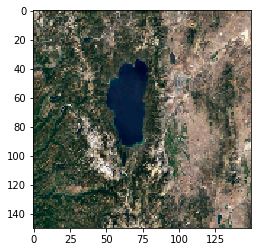

In [6]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

### Loading the VGG16 network with pretrained weights

In [7]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

### Preprocessing an input image for VGG16

In [8]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

In [9]:
img_path = 'images/MP-008-with.png'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

In [10]:
preds = model.predict(x)

In [11]:
print('Predicted:', decode_predictions(preds, top=3)[0])

('Predicted:', [(u'n09246464', u'cliff', 0.51585984), (u'n02133161', u'American_black_bear', 0.45014352), (u'n03042490', u'cliff_dwelling', 0.011832204)])


In [12]:
# Entry in the prediction vector that was maximally activated is 
# the one corresponding to the “African elephant” class, at index 386:
np.argmax(preds[0])

972

### Setting up the Grad-CAM algorithm

In [13]:
with_output = model.output[:, 972]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(with_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

### Heatmap post-processing

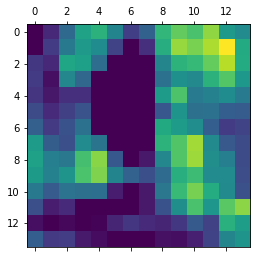

In [14]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

### Superimposing the heatmap with the original picture

In [15]:
import cv2

In [16]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('superimposed_heatmap_images/superimposed_heatmap_MP-008-with.png', superimposed_img)

True

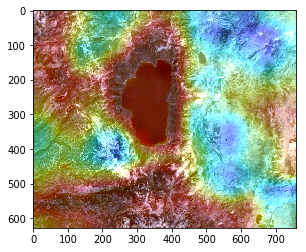

In [17]:
img = cv2.imread('superimposed_heatmap_images/superimposed_heatmap_MP-008-with.png')

plt.imshow(img)